# Import

In [1]:
#%matplotlib notebook
import numpy as np
from scipy.stats import norm
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import statistics
from scipy import signal
from cycler import cycler
import scipy.fftpack

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%matplotlib notebook

# Reading files

In [3]:
#reading routine
def read_data_file(common_folder, folder_in, Rl, N, file_type, spec_type, spec_component, run_files) :
    nb_of_runs = len(run_files)
    for run_index in list(range(nb_of_runs)) :
        folder = common_folder + "rl" + str(Rl) + "_N" + str(N) + "/" + folder_in + "run" + "%01d" % (run_index+1) + "/"
        if (run_files[run_index] < 1000) :
            file = folder + file_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%03d" % run_files[run_index] + ".table"
        else : 
            file = folder + file_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%06d" % run_files[run_index] + ".table"
        file_data = []
        print('reading file: ' + file)
        averaging_weight = (run_files[run_index]+1)/(sum(run_files)+nb_of_runs)
        for line in open(file) :
            temp_array_line = []
            if line[0] == '#' :          #skip commented lines
                continue
            else :
                temp_array_line=list(map(float, line.split( )))
                temp_array_line = [t * averaging_weight for t in temp_array_line]
                file_data.append(temp_array_line)  
        if (run_index == 0) : 
            accumulated_data = file_data.copy()
        else : 
            accumulated_data = list(map(lambda l1, l2: [sum(x) for x in zip(l1, l2)], accumulated_data, file_data))
    k = np.array(accumulated_data[0])
    nb_of_modes = np.array(accumulated_data[1])
    average_data = np.ndarray(shape=(len(accumulated_data)-2, k.shape[0]+1), dtype=float)
    for i in list(range(average_data.shape[0])) : 
        average_data[i, :] = np.array(accumulated_data[i+2])
    t = average_data[:,0]
    numpy_file_table = np.array(average_data[:,1:])
    return [k, nb_of_modes, t, numpy_file_table]

In [4]:
common_folder = "/home/gorbunov8a/data/correlations/"
folder_in = "norm_corr/"
spec_type = "lin"
spec_component = "avg"

In [5]:
# Rl = 90; N = 256
# run_windows = [122,114,117,120]
# #run_windows = [122]
# [k, nb_of_modes, t, corr_raw] = read_data_file(common_folder, folder_in, Rl, N, "two_point_corr_norms", spec_type, spec_component, run_windows)
# [k, nb_of_modes, t, avg] = read_data_file(common_folder, folder_in, Rl, N, "avg_norms", spec_type, "avg", run_windows)

In [6]:
# Rl = 160; N = 512
# run_windows = [8]
# [k, nb_of_modes, t, corr_raw] = read_data_file(common_folder, folder_in, Rl, N, "two_point_corr_norms", spec_type, spec_component, run_windows)
# [k, nb_of_modes, t, avg] = read_data_file(common_folder, folder_in, Rl, N, "avg_norms", spec_type, "avg", run_windows)

In [7]:
# Rl = 60; N = 128
# run_windows = [487, 418]
# [k, nb_of_modes, t, corr_raw] = read_data_file(common_folder, folder_in, Rl, N, "two_point_corr_norms", spec_type, spec_component, run_windows)
# [k, nb_of_modes, t, avg] = read_data_file(common_folder, folder_in, Rl, N, "avg_norms", spec_type, "avg", run_windows)

reading file: /home/gorbunov8a/data/correlations/rl60_N128/norm_corr/run1/two_point_corr_norms_lin_Cavg_wi=487.table
reading file: /home/gorbunov8a/data/correlations/rl60_N128/norm_corr/run2/two_point_corr_norms_lin_Cavg_wi=418.table
reading file: /home/gorbunov8a/data/correlations/rl60_N128/norm_corr/run1/avg_norms_lin_Cavg_wi=487.table
reading file: /home/gorbunov8a/data/correlations/rl60_N128/norm_corr/run2/avg_norms_lin_Cavg_wi=418.table


In [9]:
Rl = 40; N = 64
run_windows = [1218]
[k, nb_of_modes, t, corr_raw] = read_data_file(common_folder, folder_in, Rl, N, "two_point_corr_norms", spec_type, spec_component, run_windows)
[k, nb_of_modes, t, avg] = read_data_file(common_folder, folder_in, Rl, N, "avg_norms", spec_type, "avg", run_windows)

reading file: /home/gorbunov8a/data/correlations/rl40_N64/norm_corr/run1/two_point_corr_norms_lin_Cavg_wi=001218.table
reading file: /home/gorbunov8a/data/correlations/rl40_N64/norm_corr/run1/avg_norms_lin_Cavg_wi=001218.table


## Define parameters

In [11]:
# PARAMETERS
if (Rl == 90) :
    lmbda = 0.268 
    eta = 0.0134  
    L = 1.95
    dissipation_rate = 0.31e-04
    urms = 0.0711
elif (Rl == 60) :
    lmbda = 0.387 
    eta = 0.025  
    L = 2.27
    dissipation_rate = 2.24565e-06
    urms = 0.02838
elif (Rl == 160) :
    lmbda = 0.168712
    eta = 0.00644949
    L = 2.32193
    dissipation_rate = 0.00057841
    urms = 2.32193 
elif (Rl == 40) :
    lmbda = 0.57
    eta = 0.511e-1
    L = 2.8
    dissipation_rate = 0.145e-6
    urms = 0.11e-1
#t0=dissipation_rate**(-1/3)*L**(2/3)
t0 = L/urms
normalization_status = True

## Normalization

In [12]:
u0_avg = avg[0,]
corr = corr_raw - u0_avg*avg

In [13]:
t_length=t.shape[0]
wavenumbers_length=k.shape[0]
#k_norm_coef = L/2.0/np.pi
k_norm_coef = L
t_norm_coef = 1.0/t0
normalization = (corr[0,:])**(-1)

## Plotting params

In [14]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
default_cycler = cycler(cycler(linestyle=['-', '--', ':', '-.'])*cycler(color=colors))
plt.rc('axes', prop_cycle=default_cycler)

In [16]:
if (Rl == 90) :
    kmin = 8
    kmax = 115
elif (Rl == 60) :
    kmin = 8
    kmax = 60
elif (Rl == 160) :
    kmin = 30
    kmax = 240
elif (Rl == 40) :
    kmin = 10
    kmax = 30
nb_of_curves = 10
step = round((kmax - kmin)/nb_of_curves)
indices_of_k_to_plot=list(range(kmin,kmax,step))
#indices_of_k_to_plot.append(50)
print(indices_of_k_to_plot)

[10, 12, 14, 16, 18, 20, 22, 24, 26, 28]


# Spatial spectrum from C_2(t=0,k)

<IPython.core.display.Javascript object>


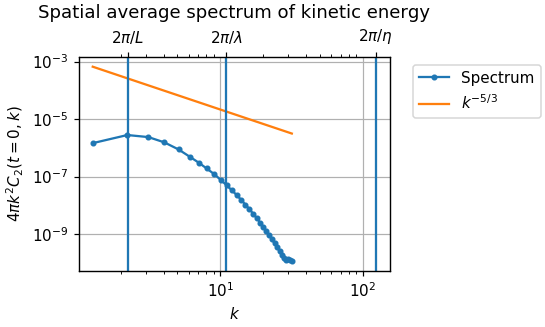

In [17]:
fig, ax = plt.subplots(figsize=(5,3), constrained_layout=True)
kinetic_energy = np.zeros(shape=wavenumbers_length, dtype=float)
for ik in list(range(wavenumbers_length)) : 
    coefficient = 4.0*np.pi*k[ik]*k[ik]
    kinetic_energy[ik] = corr[0,ik]*coefficient
ax.plot(k, kinetic_energy, '.-', label='Spectrum')
ax.plot(k, 1e-3*k**(-5.0/3.0), label=r'$k^{-5/3}$')
ax.set(xscale='log',yscale='log',xlabel=r'$k$', ylabel=r'$4 \pi k^2 C_2(t=0,k)$', title='Spatial average spectrum of kinetic energy')
vertical_lines = 2.0*np.pi*np.array([1.0/L, 1.0/lmbda, 1.0/eta])
for line in vertical_lines : ax.axvline(x=line)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid()
ax2 = ax.twiny()
ax2.set(xscale='log', yscale='log', xlim = ax.get_xlim())
ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
plt.show()

# Space-time correlations

<IPython.core.display.Javascript object>


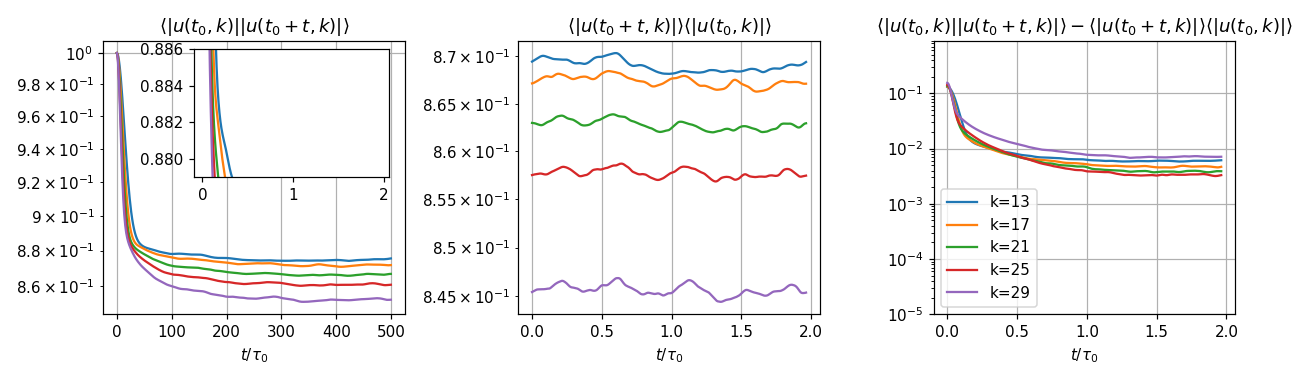

In [18]:
fig, (corr_plot, avg_plot, susbt_plot) = plt.subplots(nrows=1, ncols=3,figsize=(12,3.5), tight_layout=True)
zoom1 = corr_plot.inset_axes([0.3, 0.5, 0.65, 0.47])
#zoom2 = susbt_plot.inset_axes([0.3, 0.5, 0.65, 0.47])
for ik in indices_of_k_to_plot[1::2] :
    corr_plot.plot(t, corr_raw[:,ik]/corr_raw[0,ik])
    zoom1.plot(t/t0, corr_raw[:,ik]/corr_raw[0,ik])
    avg_plot.plot(t/t0, avg[:,ik]*avg[0,ik]/corr_raw[0,ik], label='k=%2.f' % (k[ik]))
    susbt_plot.plot(t/t0, (corr_raw[:,ik] - avg[:,ik]*avg[0,ik])/corr_raw[0,ik], label='k=%2.f' % (k[ik]))
    #zoom2.plot(t, (corr_raw[:,ik] - avg[:,ik]*avg[0,ik])/corr_raw[0,ik])
corr_plot.set(title=r'$\left< |u(t_0, k)| |u(t_0 + t, k)| \right>$', yscale='log', xlabel=r'$t/\tau_0$'); corr_plot.grid()
avg_plot.set(title=r'$\left< |u(t_0 + t, k)|\right> \left< |u(t_0, k)| \right>$', yscale='log', xlabel=r'$t/\tau_0$'); avg_plot.grid()
susbt_plot.set(ylim=[10e-6,0.9],title=r'$\left< |u(t_0, k)| |u(t_0 + t, k)| \right> -\left< |u(t_0 + t, k)|\right> \left< |u(t_0, k)| \right>$', \
               yscale='log', xlabel=r'$t/\tau_0$'); susbt_plot.grid()
susbt_plot.legend()
zoom1.set(ylim=[8.79e-1,8.86e-1], yscale="linear"); #zoom1.grid()
#zoom2.set(ylim=[10e-6,10e-4], yscale="linear"); #zoom2.grid()

# pp = PdfPages('../Images/Correlations/norm_corr_avg_subs.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()
#plt.show()

<IPython.core.display.Javascript object>


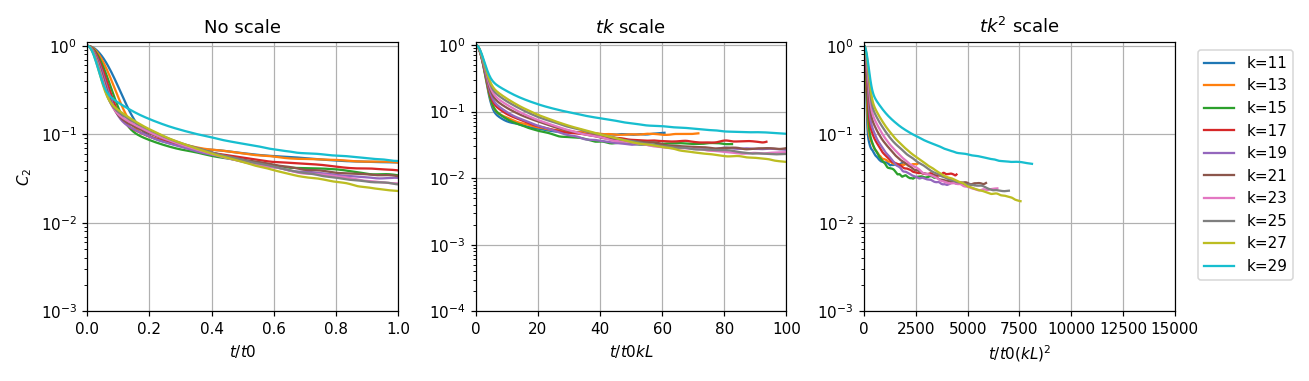

In [21]:
tk1 = 0.0
tk2 = 100.0

fig, (t_scale, tk_scale, tk2_scale) = plt.subplots(nrows=1, ncols=3,figsize=(12,3.5))
for ik in indices_of_k_to_plot :
    a = np.searchsorted(t/t0*k[ik]*L, tk1)
    b = np.searchsorted(t/t0*k[ik]*L, tk2)
    t_scale.plot(t/t0, corr[:,ik]*normalization[ik])
    tk_scale.plot(t[a:b]/t0*k[ik]*L, corr[a:b,ik]*normalization[ik])
    tk2_scale.semilogy(t[a:b]/t0*(k[ik]*L)**2, corr[a:b,ik]*normalization[ik], label='k=%2.f' % (k[ik]))
t_scale.set(xlim=[0,1.0], ylim=[10e-4,1.1],title='No scale', yscale='log', ylabel=r'$C_2$', xlabel=r'$t/t0$'); t_scale.grid()
tk_scale.set(xlim=[0,100], ylim=[10e-5,1.1],title=r'$tk$ scale', yscale='log', xlabel=r'$t/t0 kL$'); tk_scale.grid()
tk2_scale.set(xlim=[0,15000], ylim=[10e-4,1.1],title=r'$tk^2$ scale', yscale='log', xlabel=r'$t/t0 (kL)^2$'); tk2_scale.grid()
tk2_scale.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.tight_layout()
# pp = PdfPages('../Images/Correlations/norm_corr_time_scalings.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()
plt.show()

# Short times - Gaussian

In [22]:
def exp_poly_s(x,a,b,c) :
    return np.exp(a*(x**2) + b*x + c)
def exp_poly_l(x,a,b) :
    return np.exp(a*x + b)

In [24]:
tk1_gauss = 0.0
tk2_gauss = 5.0

optim_coef_s = np.ndarray(shape=(wavenumbers_length, 3), dtype=float)
for ik in range(wavenumbers_length) :
    a = np.searchsorted(t/t0*k[ik]*L, tk1_gauss)
    b = np.searchsorted(t/t0*k[ik]*L, tk2_gauss)
    xdata = t[a:b]/t0   # t'k' variable
    #print('[debug] Fitting using', np.count_nonzero(xdata), 'points')
    ydata = np.log(corr[a:b, ik]*normalization[ik])
    try :
        optim_coef_s[ik, :] = np.polyfit(xdata, ydata, 2)
    except :
        print('Failed polyfit for ik = ', ik)
        optim_coef_s[ik,:].fill(np.nan)
        continue

<IPython.core.display.Javascript object>


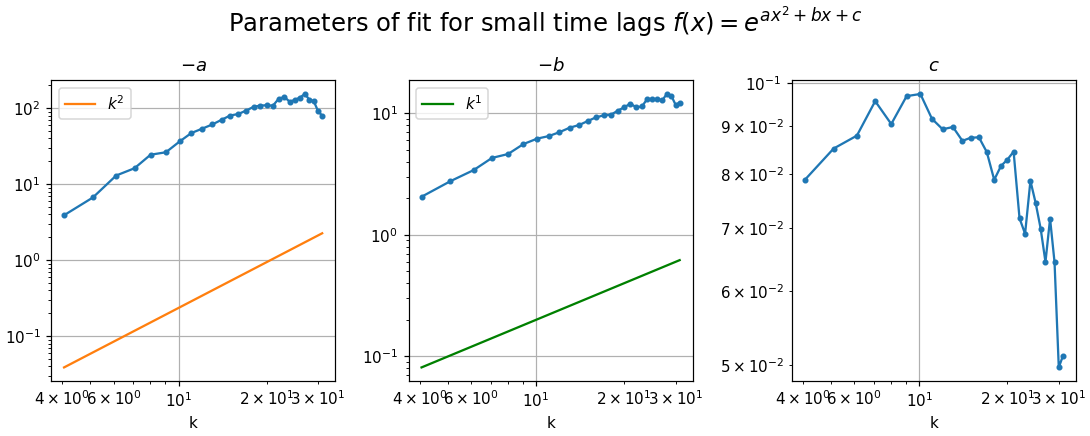

In [25]:
# plot fitting coeffiecients
ik1 = 3; ik2 = wavenumbers_length-1

fig, (ax_a, ax_b, ax_c) = plt.subplots(nrows=1, ncols=3,figsize=(10,4), constrained_layout=True)
ax_a.plot(k[ik1:ik2], -optim_coef_s[ik1:ik2, 0], '.-')
ax_a.plot(k[ik1:ik2], 3e-4*((k[ik1:ik2]*L)**2), '-', label=r'$k^2$')
ax_a.legend(loc='best')
ax_b.plot(k[ik1:ik2], -optim_coef_s[ik1:ik2, 1], '.-')
ax_b.plot(k[ik1:ik2], 0.02*(k[ik1:ik2]), 'g-', label=r'$k^1$')
ax_b.legend(loc='best')
ax_c.plot(k[ik1:ik2], optim_coef_s[ik1:ik2, 2], '.-')
ax_a.set(xscale='log', yscale='log', title=r'$-a$', xlabel='k'); ax_a.grid(); #ax_a.legend()
ax_b.set(xscale='log', yscale='log', title=r'$-b$', xlabel='k'); ax_b.grid(); 
ax_c.set(xscale='log', yscale='log', title=r'$c$', xlabel='k'); ax_c.grid()
fig.suptitle('Parameters of fit for small time lags $f(x) = e^{a x^2 + b x + c}$', fontsize=16)

# pp = PdfPages('../Images/Correlations/norm_corr_fit_short.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()
plt.show()

<IPython.core.display.Javascript object>


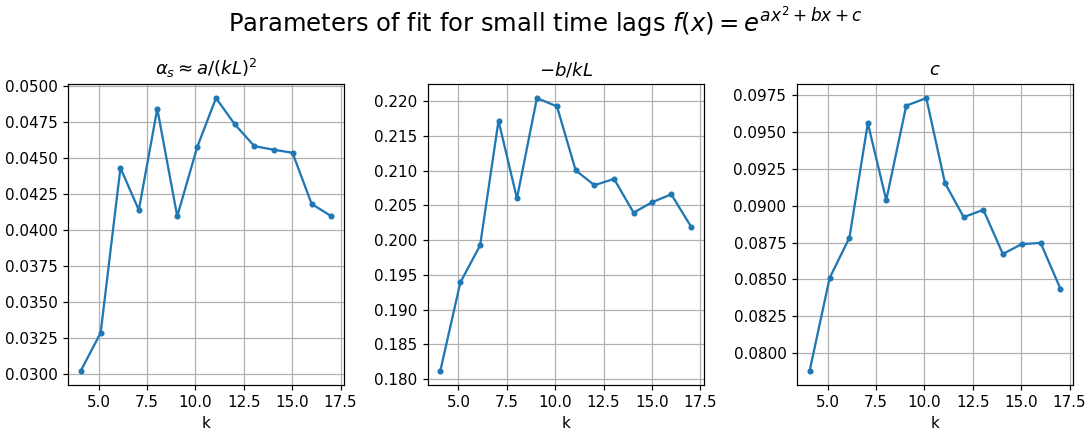

In [27]:
# plot fitting coeffiecients
ik1 = 3; ik2 = wavenumbers_length-15
sl = np.s_[ik1:ik2]
fig, (ax_a, ax_b, ax_c) = plt.subplots(nrows=1, ncols=3,figsize=(10,4), constrained_layout=True)
ax_a.plot(k[sl], -optim_coef_s[sl, 0]/(k[sl]*L)**2, '.-')
ax_b.plot(k[sl], -optim_coef_s[sl, 1]/(k[sl]*L), '.-')
ax_c.plot(k[sl], optim_coef_s[sl, 2], '.-')
ax_a.set(xscale='linear', yscale='linear', title=r'$\alpha_s \approx a/(kL)^2$', xlabel='k'); ax_a.grid(); #ax_a.legend()
ax_b.set(xscale='linear', yscale='linear', title=r'$-b/k L$', xlabel='k'); ax_b.grid(); 
ax_c.set(xscale='linear', yscale='linear', title=r'$c$', xlabel='k'); ax_c.grid()
fig.suptitle('Parameters of fit for small time lags $f(x) = e^{a x^2 + b x + c}$', fontsize=16)

# pp = PdfPages('../Images/Correlations/norm_corr_fit_alphas.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()
plt.show()

# Large time lags

In [43]:
# fitting range : 
tk1_long = 7.0
tk2_long = 50.0

optim_coef_l = np.ndarray(shape=(wavenumbers_length, 2), dtype=float)
for ik in range(5,wavenumbers_length) :
    a = np.searchsorted(t/t0*k[ik]*L, tk1_long)
    b = np.searchsorted(t/t0*k[ik]*L, tk2_long)
    xdata = t[a:b]/t0
    #print('[debug] Fitting using', np.count_nonzero(xdata), 'points')
    try :
        ydata = np.log(corr[a:b, ik]*normalization[ik])
        optim_coef_l[ik, :] = np.polyfit(xdata, ydata, 1)
    except :
        print('Failed optimization for ik = ', ik)
        optim_coef_l[ik,:].fill(np.nan)
        continue
#     max_param_std = 1000
#     if (np.count_nonzero(np.sqrt(np.diag(cov_matrix2[ik,:,:])>max_param_std)) > 0) :
#         print('point out ik = ', ik)
#         cov_matrix2[ik,:,:].fill(np.nan)
#         optim_coef2[ik,:].fill(np.nan)

<IPython.core.display.Javascript object>


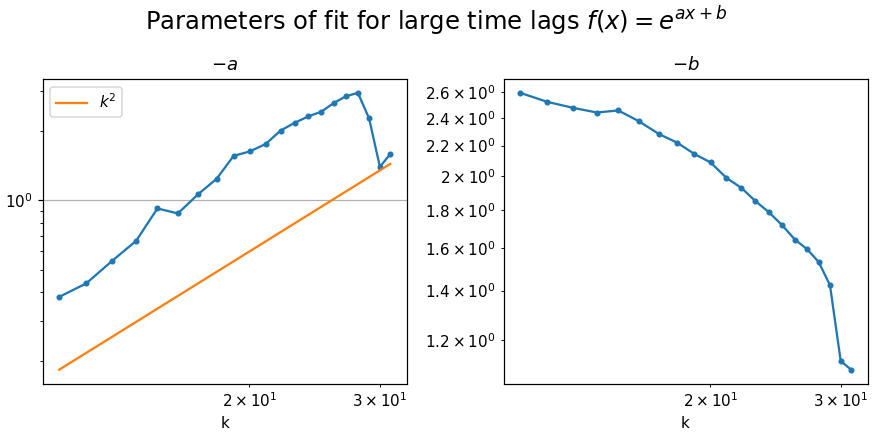

In [44]:
# plot fitting coeffiecients
fig, (ax_a, ax_b) = plt.subplots(nrows=1, ncols=2,figsize=(8,4), constrained_layout=True)
ik1 = 10; ik2 = wavenumbers_length-1
sl = np.s_[ik1:ik2]
ax_a.plot(k[sl], -optim_coef_l[sl, 0],'.-')
ax_a.plot(k[sl], 1.5e-3*(k[sl])**2 ,'-',label=r'$k^2$')
#ax_a.plot(k[ik1:ik2]/k_norm_coef, 0.5e-1*(k[ik1:ik2]/k_norm_coef) ,'-',label=r'$k^1$')
ax_a.legend(loc='best')
ax_b.plot(k[sl], -optim_coef_l[sl, 1],'.-')
ax_a.set(xscale='log', yscale='log',title=r'$-a$', xlabel='k'); ax_a.grid()
ax_b.set(xscale='log', yscale='log',title=r'$-b$', xlabel='k'); ax_b.grid()
fig.suptitle(r'Parameters of fit for large time lags $f(x)=e^{a x + b}$', fontsize=16)
# pp = PdfPages('../Images/Correlations/norm_corr_fit_long.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()
plt.show()

<IPython.core.display.Javascript object>


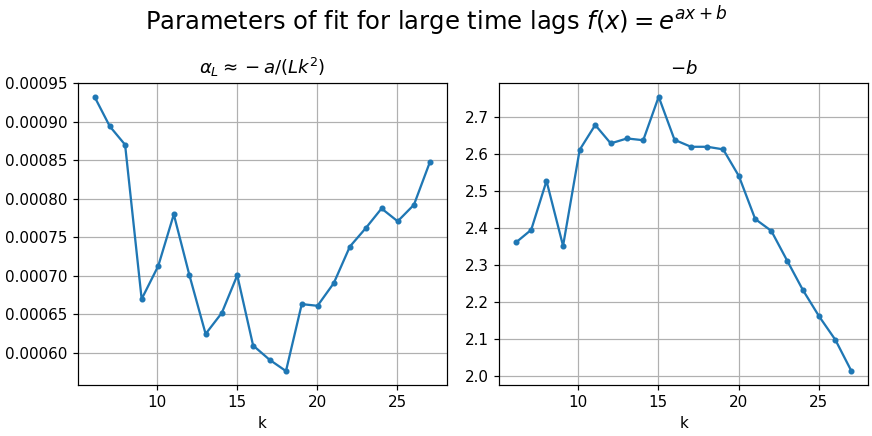

In [41]:
# plot fitting coeffiecients
fig, (ax_a, ax_b) = plt.subplots(nrows=1, ncols=2,figsize=(8,4), constrained_layout=True)
ik1 = 5; ik2 = wavenumbers_length-5
sl = np.s_[ik1:ik2]
ax_a.plot(k[sl], -optim_coef_l[sl, 0]/(L*k[sl]**2),'.-')
ax_b.plot(k[sl], -optim_coef_l[sl, 1],'.-')
ax_a.set(xscale='linear', yscale='linear',title=r'$\alpha_L \approx -a/(L k^2)$', xlabel='k'); ax_a.grid()
ax_b.set(xscale='linear', yscale='linear',title=r'$-b$', xlabel='k'); ax_b.grid()

fig.suptitle(r'Parameters of fit for large time lags $f(x)=e^{a x + b}$', fontsize=16)
# pp = PdfPages('../Images/Correlations/norm_corr_fit_alphal.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()
plt.show()

<IPython.core.display.Javascript object>


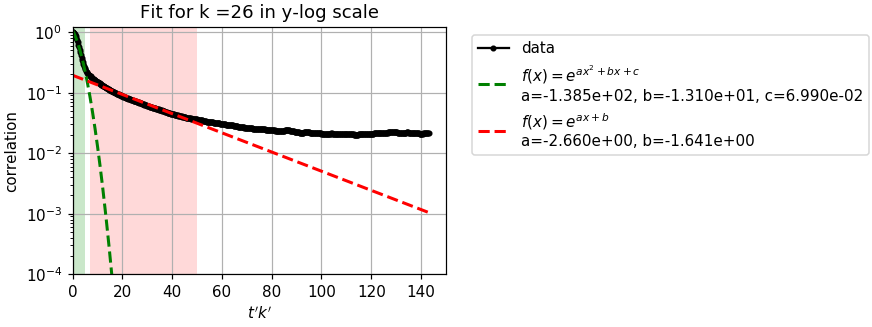

In [45]:
# Example of the exponential fit for one wavenumber
ik = 25
a = np.searchsorted(t/t0*k[ik]*L, 0)
b = np.searchsorted(t/t0*k[ik]*L, tk1_long+8)

fig, (ax_log) = plt.subplots(nrows=1, ncols=1, figsize=(8,3), constrained_layout=True)
ax_log.plot(t/t0*k[ik]*L, corr[:, ik]*normalization[ik], 'k.-', label='data')
ax_log.plot(t/t0*k[ik]*L, exp_poly_s(t[:]/t0, *optim_coef_s[ik,:]), 'g--', linewidth=2, label=r'$f(x) = e^{a x^2 + bx + c}$' + "\n" + 'a=%5.3e, b=%5.3e, c=%5.3e' % tuple(optim_coef_s[ik,:]))
ax_log.plot(t/t0*k[ik]*L, exp_poly_l(t[:]/t0, *optim_coef_l[ik,:]), 'r--', linewidth=2, label=r'$f(x) = e^{ax + b}$' + "\n" + 'a=%5.3e, b=%5.3e' % tuple(optim_coef_l[ik,:]))
ax_log.axvspan(tk1_long, tk2_long, facecolor='red', alpha=0.15)
ax_log.axvspan(tk1_gauss, tk2_gauss, facecolor='#2ca02c', alpha=0.25)
ax_log.set(yscale="log", ylabel='correlation', xlabel=r'$t^\prime k^\prime$', title='Fit for k =%2.f' % (k[ik]) +' in y-log scale'); ax_log.grid()
ax_log.set(ylim=[10e-5,1.2], xlim=[0,150])
ax_log.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# pp = PdfPages('../Images/Correlations/norm_corr_2fits_plot.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()
plt.show()

# Relation btw aL and aS

<IPython.core.display.Javascript object>


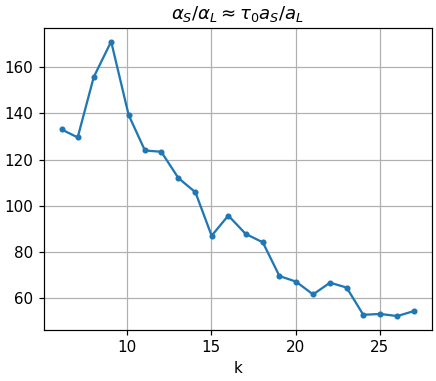

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(4,3.5), constrained_layout=True)
ik1 = 5; ik2 = wavenumbers_length-5
sl = np.s_[ik1:ik2]
ax.plot(k[sl], optim_coef_s[sl, 0]/optim_coef_l[sl, 0],'.-')
ax.set(xscale='linear', yscale='linear',title=r'$\alpha_S/\alpha_L \approx \tau_0 a_S/a_L$', xlabel='k'); ax.grid()
# pp = PdfPages('../Images/Correlations/norm_corr_fit_relation.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()
plt.show()

# Theoretical result

<IPython.core.display.Javascript object>


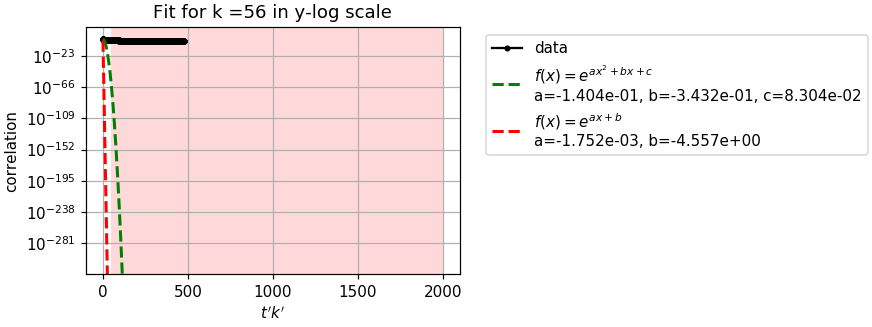

In [31]:
# Example of the exponential fit for one wavenumber
ik = 55
a = np.searchsorted(t/t0*k[ik]*L, 0)
b = np.searchsorted(t/t0*k[ik]*L, tk1_long+8)

al_th = -optim_coef_s[ik, 0]/(k[ik]*urms)**2/0.248

fig, (ax_log) = plt.subplots(nrows=1, ncols=1, figsize=(8,3), constrained_layout=True)
ax_log.plot(t/t0*k[ik]*L, corr[:, ik]*normalization[ik], 'k.-', label='data')
ax_log.plot(t/t0*k[ik]*L, exp_poly_s(t[:], *optim_coef_s[ik,:]), 'g--', linewidth=2, label=r'$f(x) = e^{a x^2 + bx + c}$' + "\n" + 'a=%5.3e, b=%5.3e, c=%5.3e' % tuple(optim_coef_s[ik,:]))
ax_log.plot(t/t0*k[ik]*L, exp_poly_l(t[:], -al_th*urms*L*k[ik]**2, optim_coef_l[ik,1]), 'r--', linewidth=2, label=r'$f(x) = e^{ax + b}$' + "\n" + 'a=%5.3e, b=%5.3e' % tuple(optim_coef_l[ik,:]))
ax_log.axvspan(tk1_long, tk2_long, facecolor='red', alpha=0.15)
ax_log.axvspan(tk1_gauss, tk2_gauss, facecolor='#2ca02c', alpha=0.25)
ax_log.set(yscale="log", ylabel='correlation', xlabel=r'$t^\prime k^\prime$', title='Fit for k =%2.f' % (k[ik]) +' in y-log scale'); ax_log.grid()
#ax_log.set(ylim=[10e-5,1.2], xlim=[0,100])
ax_log.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()